In [1]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans


from utils import cleaning_utils
from utils import cluster_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

### 1 Clustering the terms

<div class="alert alert-block alert-info">
We'll also try an unsupervised clustering-based approach. The aim is to assign a domain to UNSEEN spans. <br>
    
Using unsupervised clustering means we have to pick a value for K ~ the number of clusters. K determines roughly how many terms are filtered (each cluster that has a background term in it), a low K will have many terms removed and a high K will have few terms removed.
</div>

* As a heuristic for determining a reasonable value for K we rely on the Elbow method and sillhouette score; these are not optimal solutions but this doesn't matter much in our case. 
  * In general, our dataset is larger and more diverse than usually desired with KMeans. As an example, a rule of thumb for selecting K is the square root of half the number of samples `k = (16000/2)**.5 = 89.4`. This is a completely unrealistic value of K for our usecase, as it would mean there are only 90-odd concepts that occur in our sets of input corpora.
  * However, we will see that (1) the elbow method, (2) sillhouette scores, as well as (3) gap statistics indicate how hard it is to cluster a large set of text embeddings. 
  
Based on these heuristics we'll pick a K that could reasonable well distinguish whether an unseen term is within the AEC domain.
  

In [2]:
embedding_output_fp = Path.cwd().joinpath("data", "term_embedding")
embedding_output_fp.mkdir(parents=True, exist_ok=True) # create directory if it doesn't exist
# we'll use the same embeddings directory to store our clustering data
unique_background_spans = pickle.load(open(embedding_output_fp.joinpath("unique_background_spans.pkl"), 'rb'))
unique_spans = pickle.load(open(embedding_output_fp.joinpath("unique_spans.pkl"), 'rb'))
standardised_clustering_data = pickle.load(open(embedding_output_fp.joinpath("standardised_embeddings.pkl"), 'rb'))

In [3]:
# clustering approach (I think I'll simply use the kNN approach)
def compute_clusters_sklearn(standardised_clustering_data, cluster_model_fp: Path, num_clusters=10):
    """
    Note that this clustering function relies on the CPU. It won't be able to compute clusters for large 
    amounts of inputs, e.g., 100.000 spans. When using a large number of clusters (e.g. 20K) it is also
    a lot slower than a GPU implementation for. Or it may simply not converge! 
    For large inputs/num_clusters you'll need to use compute_clusters_kmcuda, and have access to a GPU.
    """
    print(f"Computing {num_clusters} clusters from scratch, using sklearn on the CPU")
    start_time = time.time()
    sklearn_kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5, n_init=1, random_state=14,
                            tol=0.0001, verbose=0)
    assignments = sklearn_kmeans.fit_predict(standardised_clustering_data)
    centroids = sklearn_kmeans.cluster_centers_
    print("Clustering took {}".format(time.time() - start_time))
    with open(cluster_model_fp, 'wb') as f:
        pickle.dump((centroids, assignments), f)

In [6]:
clustering_type = "sklearn"   # deprecated; we're only using the sklearn implementation of kmeans in this notebook
# Computing clusters on the CPU 
min_num_clusters = 2000
max_num_clusters = 7000
steps = 1000
for num_clusters in range(min_num_clusters, max_num_clusters + 1, steps):
    cluster_file = embedding_output_fp.joinpath(f"sklearn_{num_clusters}_clusters.pkl")
    if not os.path.exists(cluster_file):
        compute_clusters_sklearn(standardised_clustering_data, cluster_file, num_clusters)
    else:
        print(f"sklearn cluster file exists for {num_clusters} clusters")

sklearn cluster file exists for 500 clusters
sklearn cluster file exists for 1000 clusters
sklearn cluster file exists for 1500 clusters
sklearn cluster file exists for 2000 clusters
sklearn cluster file exists for 2500 clusters
sklearn cluster file exists for 3000 clusters
sklearn cluster file exists for 3500 clusters
sklearn cluster file exists for 4000 clusters
sklearn cluster file exists for 4500 clusters
sklearn cluster file exists for 5000 clusters
sklearn cluster file exists for 5500 clusters
sklearn cluster file exists for 6000 clusters
sklearn cluster file exists for 6500 clusters
sklearn cluster file exists for 7000 clusters
sklearn cluster file exists for 7500 clusters
sklearn cluster file exists for 8000 clusters
sklearn cluster file exists for 8500 clusters
sklearn cluster file exists for 9000 clusters
sklearn cluster file exists for 9500 clusters
sklearn cluster file exists for 10000 clusters
sklearn cluster file exists for 10500 clusters
sklearn cluster file exists for 1

In [8]:
# we'll use all clustering files that were created so far to compute score, you can change this line if you'd like to
clustering_files = embedding_output_fp.glob(f'{clustering_type}_*.pkl')

Computing elbow and silhouette (if not too many num_clusters) scores.


0it [00:00, ?it/s]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_4500_clusters.pkl


1it [00:10, 10.90s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_5000_clusters.pkl


2it [00:21, 10.84s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_3500_clusters.pkl


3it [00:32, 10.60s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_2000_clusters.pkl


4it [00:41, 10.31s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_12000_clusters.pkl


5it [00:55, 11.53s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_500_clusters.pkl


6it [01:05, 10.86s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_2500_clusters.pkl


7it [01:15, 10.67s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_3000_clusters.pkl


8it [01:25, 10.62s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_5500_clusters.pkl


9it [01:37, 10.91s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_4000_clusters.pkl


10it [01:48, 10.85s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_1000_clusters.pkl


11it [01:57, 10.51s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_11500_clusters.pkl


12it [02:11, 11.43s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_10000_clusters.pkl


13it [02:24, 11.91s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_7500_clusters.pkl


14it [02:36, 11.95s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_6000_clusters.pkl


15it [02:47, 11.81s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_9000_clusters.pkl


16it [03:00, 12.06s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_8500_clusters.pkl


17it [03:12, 12.14s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_6500_clusters.pkl


18it [03:24, 11.98s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_7000_clusters.pkl


19it [03:36, 11.97s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_8000_clusters.pkl


20it [03:50, 12.49s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_9500_clusters.pkl


21it [04:02, 12.58s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_1500_clusters.pkl


22it [04:12, 11.71s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_10500_clusters.pkl


23it [04:25, 12.09s/it]

Working on: /Users/rubenkruiper/dev/irec/data/term_embedding/sklearn_11000_clusters.pkl


24it [04:38, 11.62s/it]


Plotting the figure


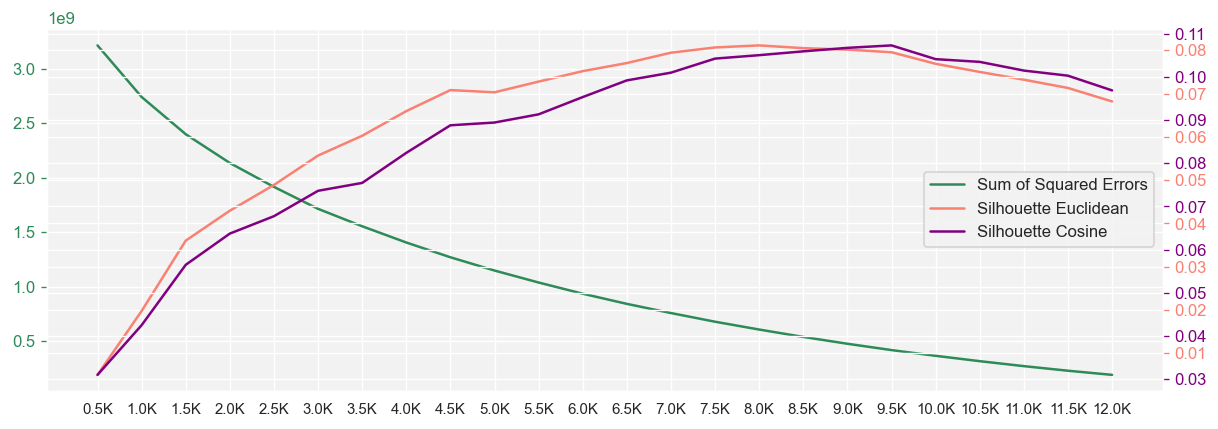

In [9]:
# This takes a bit of time; 6-10 minutes per cluster size for 2000-6000 clusters 
# but resulting scores are saved in a csv and reused
es = cluster_utils.ElbowAndSilhouette(embedding_output_fp)
es.compute_scores_for_models(clustering_type, clustering_files)

* Sum of Squared Errors (SSE) is an indication of the sum of squared distances between points in a cluster and the cluster centroid.
* The silhouette score of a point measures how close that point lies to its nearest neighbor points, across all clusters. 

While SSE and the silhouette score are often used for determining a good value for K, they do not always provide the right type of insight in the optimal K. Better alternatives exist (Schubert, 2022) and one of these options is the gap statistic (Tibshirani et al., 2001).

In [ ]:
## Gap statistic; 
## Uncomment to run, takes a while and basically ends up saying that K should be close to the number of input data points
# optimalK = OptimalK(n_jobs=6, parallel_backend='joblib')
# n_clusters = optimalK(standardised_clustering_data, cluster_array=np.arange(250, 16251, 500))
# optimalK.gap_df.head()

In [ ]:
# print(f"Optimal number of clusters: {n_clusters}")
# plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
# plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
#             optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
# plt.grid(True)
# plt.xlabel('Cluster Count')
# plt.ylabel('Gap Value')
# plt.title('Gap Values by Cluster Count')
# plt.show()

* Based on the Elbow score, we might expect K to lie around 3000. 
* Based on the sillhouette scores the ideal K may be closer to 7500.
* Based on the Gap Statistics K should be somewhere closer to 15000.

We are using the cluster-assignment to distinguish between AEC and non-AEC terms. Based on the number of non-domain terms in a cluster, we will assign a likelihood of the cluster being within the AEC domain. A large number of clusters will make it hard to classify unseen terms into a group of similar spans. A very small number of clusters will make it hard to distinguish whether a cluster contains mostly AEC or non-AEC terms.

### 2 Filtering terms based on cluster assignment

<div class="alert alert-block alert-info">
We first create a lookup-dictionary for the embedding and assigned cluster of each span
</div>

In [10]:
# Based on the above we will set the number of clusters to 4500
chosen_num_clusters = 4500
cluster_model_to_use = embedding_output_fp.joinpath(f'{clustering_type}_{chosen_num_clusters}_clusters.pkl')

In [11]:
centroids, assignments = pickle.load(open(cluster_model_to_use, 'rb'))
cluster_dict_creator = cluster_utils.ClusterDict(unique_background_spans, 
                                                 unique_spans, 
                                                 standardised_clustering_data,  # important to use standardised embeddings
                                                 centroids, 
                                                 assignments,
                                                 embedding_fp=embedding_output_fp)

In [12]:
phrase_cluster_dict, clusters_with_background_terms = cluster_dict_creator.prep_cluster_dict(chosen_num_clusters)

Computing the cluster dictionary.


In [13]:
# reload kNN based features
span_features_df = pd.read_csv(embedding_output_fp.joinpath("span_features.csv"), index_col=1)
columns = ['span', 'num_background_neighbours', 'num_foreground_neighbours', 'foreground_cnt', 'background_cnt', 'TFIDF_fore_back']
span_features_df.set_axis(columns, axis='columns', inplace=True)
span_features_df[:3]

,span,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
span_idx,,,,,,
0,the safety devices,305,195,3,0,0.580085
1,the application,309,191,6,155,0.027328
2,the storage vessel,171,329,7,0,0.843945


In [14]:
row = span_features_df.loc[span_features_df['span'] == 'vessel']
row['TFIDF_fore_back'].values[0]

0.8298175215895447

In [15]:
def cluster_feature_filter(all_spans_in_cluster, span_features_df):
    """
    We want to (1) identify clusters that we might want to remove and (2) spans that we might want to keep within
    those clusters. Could play around with different settings or add features here.
    """
    
    # span-level features
    min_TFIDF = .5
    minimum_foreground_neighbours = 200
    
    spans_making_the_cut = []
    
    for span in all_spans_in_cluster:
        row = span_features_df.loc[span_features_df['span'] == span]
        
#         nbckgrn = row['num_background_neighbours'].values[0]
        nfrgrn = row['num_foreground_neighbours'].values[0]
#         fc = row['foreground_cnt'].values[0]
#         bc = row['background_cnt'].values[0]
        TFIDF = row['TFIDF_fore_back'].values[0]
        
        if TFIDF >= min_TFIDF and nfrgrn >= minimum_foreground_neighbours:
            spans_making_the_cut.append(span)
     
    # cluster-level feature
#     ratio_fore_ground_background = len(background_spans_in_cluster) / len(all_spans_in_cluster)
    ratio_making_the_cut = 1 - (len(spans_making_the_cut) / len(all_spans_in_cluster))
    
    
    # cluster-level decision
#     cluster_ratio_w = 1
    domain_spans_w = 1
#     if (ratio_fore_ground_background * cluster_ratio_w) + (ratio_making_the_cut * domain_spans_w) > 1:
    if ratio_making_the_cut > .5: # at least 30% of the terms in the cluster are highly likely domain terms
        # cluster will be removed!
        return [False, spans_making_the_cut]
    else:
        
        return [True, spans_making_the_cut]
    
        

In [16]:
# Preparing the filter based on cluster assignment
domain_terms = []
filtered_terms = []
clusters_to_filter = []
potential_domain_terms = []

max_terms_to_show = 5
for cluster_id in phrase_cluster_dict.keys():
    all_spans_in_cluster = [span for _, span in phrase_cluster_dict[cluster_id]]
    cluster_made_it, spans_that_made_it = cluster_feature_filter(all_spans_in_cluster, 
                                                                  span_features_df)
    if not cluster_made_it:
        filtered_terms += [x for x in all_spans_in_cluster if x not in spans_that_made_it]
        potential_domain_terms += spans_that_made_it
        clusters_to_filter.append(cluster_id)
    else:
        domain_terms += all_spans_in_cluster
    
assert len(unique_spans) == len(domain_terms + filtered_terms + potential_domain_terms)

In [17]:
print("{} terms assigned to AEC domain ({:.2f}%)".format(len(domain_terms), len(domain_terms)/len(unique_spans)*100))
random.sample(domain_terms, 15)

10038 terms assigned to AEC domain (61.10%)


['For cavities',
 'the fabric elements',
 'lecture / conference facilities',
 'outbuildings',
 'pitched roofs',
 'the side of',
 'buildings Introduction',
 'exemption',
 'loadbearing capacity',
 'entrance door',
 'electrical output',
 'building materials',
 'speeds',
 'Specification [ 2001 ]',
 'Fixing systems']

In [18]:
print("{} potential domain terms from filtered clusters:  ({:.2f}%)".format(len(potential_domain_terms), len(potential_domain_terms)/len(unique_spans)*100))
if potential_domain_terms:
    [print(x) for x in random.sample(potential_domain_terms, 15)]


907 potential domain terms from filtered clusters:  (5.52%)
base
means warning
the attacks
a band of
Index of performance I )
lighting
the types of
Date
the concentrations
the schemes
the publication
BA
the standard
sides member
an example


In [19]:
print(f"Number of filtered clusters: {len(clusters_to_filter)} out of {chosen_num_clusters}")
print("{} terms were filtered ({:.2f}%)".format(len(filtered_terms), len(filtered_terms)/len(unique_spans)*100))
if filtered_terms:
    [print(x) for x in random.sample(filtered_terms, 15)]
else:
    print("Change your filtering settings, even background terms aren't filtered right now.")

Number of filtered clusters: 1479 out of 4500
5485 terms were filtered (33.38%)
safety principles
a valid result
one individual
biological material
accordance 4 3
a re - assessment
the end user
issued
the applicable regulatory requirements
AIDC
Any device
Article 112
flammable
a fault condition
comprehensive experience


In [20]:
removed_terms = [span for span in unique_spans if span in filtered_terms and span not in unique_background_spans]

In [21]:
print("{} foreground terms were removed through filtering with clusters ({:.2f}%)".format(len(removed_terms), len(removed_terms)/(len(unique_spans)-len(unique_background_spans))*100))
removed_terms

378 foreground terms were removed through filtering with clusters (3.69%)


['the safety devices',
 'a provision',
 'a safety device',
 'health safety requirements',
 'the commissioning work',
 'a person registered',
 'product details',
 'the basic requirements',
 'the relevant version',
 'rodent control',
 'the test section',
 'The manner',
 'The test',
 'test procedure',
 'period of',
 'the access',
 'the permission',
 'provided',
 'the consent',
 'Quality control',
 'and conformity',
 'a competent person self - certification scheme',
 'the conservation officer',
 'designed',
 'the necessary',
 'a visual inspection',
 'the client',
 'the such',
 'the safe operation',
 'a visual check',
 'the product standards',
 'the standard of provision',
 'a standard of provision',
 'standards referred',
 'approved documents',
 'the considerations',
 'design approaches',
 'evidence of',
 'an energy performance certificate',
 'an output report',
 'The output report',
 'a regulation',
 'statutory guidance',
 'criterion',
 'the energy performance certificate',
 'the claimed 

* some more cluster-based insights

In [22]:
cluster_sizes = [len(v) for v in phrase_cluster_dict.values()]
print('Average number of terms per cluster: {:.2f}'.format(sum(cluster_sizes)/len(cluster_sizes)))


Average number of terms per cluster: 3.65


In [23]:
# Check the largest cluster(s)
largest_cluster_size = np.max([len(v) for v in phrase_cluster_dict.values()])
print("Largest cluster is size: ", largest_cluster_size)
[largest_cluster] = [phrase_cluster_dict[k] for k, v in phrase_cluster_dict.items() if len(v) == largest_cluster_size]
lc_terms = [s for _, s in largest_cluster]
print("Number of filtered terms in largest cluster: ", len([x for x in lc_terms if x in filtered_terms]))

Largest cluster is size:  100
Number of filtered terms in largest cluster:  57


In [24]:
# check the smallest clusters, select 10 examples
smallest_clusters = [phrase_cluster_dict[k] for k, v in phrase_cluster_dict.items() if len(v) == 1]
print("Number of smallest clusters with size 1: ", len(smallest_clusters))

for cluster in random.sample(smallest_clusters, 10):
    print(cluster[0][1])

Number of smallest clusters with size 1:  2239
radio waves
the pressure flow rate
the European Food Safety Authority
Calorifiers
Economic operators
concert halls
COUNCIL DIRECTIVE 93 / 42 / EEC of 14 June 1993
the middle half of
ax m ma m x
primary schools


### 3 Suggesting similar terms for Uniclass

<div class="alert alert-block alert-info">
Here we predict (1) expansion candidates and (2) potential inflections (based on Levenshtein distance) for a given term. 
</div>


* We run our algorithm on all Uniclass terms to get a feel for the output we generate.

In [25]:
# same emedder as before
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'
IDF_path = embedding_output_fp.joinpath("IDF_weights.json")
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp=embedding_output_fp,
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
class ClusterAssignment:
    def __init__(self, pkl_model, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter):
        """
        It's important to use the standardised clustering data here!
        """
        self.centroids, self.assignments = pickle.load(open(pkl_model, 'rb'))
        self.num_clusters = int(max(self.assignments) + 1)
        
        # set up sklearn for prediction
        cpu_centroids = np.nan_to_num(self.centroids, copy=True, nan=0.0, posinf=None, neginf=None)
        self.cpu_clusterer = KMeans(self.num_clusters, init=cpu_centroids, n_init=1, max_iter=1, tol=0)
        print("[Clustering] Initialising sklearn kMeans with 1 iteration.")
        self.cpu_clusterer.fit(standardised_clustering_data)
        
        self.embedder = embedder
        self.unique_span_dict = dict(zip(unique_spans, standardised_clustering_data))
        self.cluster_dict = phrase_cluster_dict
        self.clusters_to_filter = clusters_to_filter
    

    def sklearn_assign(self, to_be_clustered: List[cluster_utils.ToBeClustered]) -> List[cluster_utils.ToBeClustered]:
        """
        Using SciKit Learn's CPU implementation of KMeans to assign cluster IDs to a span or list of spans.

        :param to_be_predicted: A `str` or `list` of strings for which a cluster ID will be computed.
        :return :   List of cluster IDs.
        """
        # Note: we try to avoid iteratively assigning clusters for each item in a list - don't think we parallelize more
        embeddings = [s.embedding for s in to_be_clustered]
        arrays = [np.ones([1, 768]).astype(np.float32) for _ in to_be_clustered]

        for i, e in enumerate(embeddings):
            arrays[i][0] = np.stack(e.squeeze())  # .astype(np.float16)

        assignments = []
        for arr in arrays:
            assignments.append(self.cpu_clusterer.predict(arr))

        for idx, assignment in enumerate(assignments):
            to_be_clustered[idx].cluster_id = str(int(assignment))
#             print(f"assigned ID: {str(int(assignment))}")
            to_be_clustered[idx].distance_to_centroid = np.sum(np.absolute(embeddings[idx]-self.centroids[assignment]))
            to_be_clustered[idx].all_neighbours = self.cluster_dict[str(int(assignment))]

        return to_be_clustered
    
    def get_top_neighbours(self, 
                           text_inputs : Union[List[str], str], 
                           cosine_sim_threshold: float = 0.7, 
                           top_k: int = 3,
                           return_non_aec=False):
        if type(text_inputs) == str:
            NON_AEC = False
            tbc = cluster_utils.ToBeClustered(text_inputs, embedder)
            [tbc] = self.sklearn_assign([tbc])
            if tbc.cluster_id in self.clusters_to_filter:
#                 print(f"Potentially non-AEC domain: {tbc.text}")
                NON_AEC = True
                
            if not return_non_aec and NON_AEC:
                return [], []
            else:
                neighbours, inflections = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                return neighbours, inflections
        else:
            tbcs = [cluster_utils.ToBeClustered(t, embedder) for t in text_inputs]
            tbcs = self.sklearn_assign(tbcs)
            neighbours = []
            inflections = []
            for tbc in tbcs:
                NON_AEC = False
                if tbc.cluster_id in self.clusters_to_filter:
#                     print(f"Potentially non-AEC domain: {tbc.text}")
                    NON_AEC = True
                if not return_non_aec and NON_AEC:
                    neighbours.append([])
                    inflections.append([])
                else:
                    n, i = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                    neighbours.append(n)
                    inflections.append(i)
            return neighbours, inflections
        

In [27]:
cluster_assigner = ClusterAssignment(cluster_model_to_use, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter)

[Clustering] Initialising sklearn kMeans with 1 iteration.


* some examples of assigning clusters and identifying neighbours for spans:

In [28]:
# example str input
example_string = "party wall"
neighbours, inflections = cluster_assigner.get_top_neighbours(example_string, cosine_sim_threshold=.7)
print("neighbours", neighbours)
print("inflections", inflections)

neighbours []
inflections ['party walls', 'Party walls']


In [29]:
# example list of str input
example_strings = ["structural member", "control equipment"]
neighbours, inflections = cluster_assigner.get_top_neighbours(example_strings, 
                                                              cosine_sim_threshold=.7, 
                                                              return_non_aec=True)
for idx, (neighbour_list, inflection_list) in enumerate(zip(neighbours, inflections)):
    print("Input term: ", example_strings[idx])
    print("Neighbours", neighbour_list)
    print("Inflections", inflection_list, "\n")


Input term:  structural member
Neighbours []
Inflections ['structural members'] 

Input term:  control equipment
Neighbours ['test equipment']
Inflections ['control equipment'] 



<div class="alert alert-block alert-info">
We read Uniclass terms from a .ttl file that we have previoulsy prepared.
</div>

In [30]:
def group_ttl_lines(text):
    groups = []
    current_group = []
    for idx, line in enumerate(text.split("\n")):
        if line == '':
            if current_group:
                groups.append(current_group)
            current_group = []
        else:
            current_group.append(line)
            if idx+1 == len(text.split("\n")):
                groups.append(current_group)
    return groups

In [31]:
def grab_uids_and_labels_with_definition(groups):
    uid_dict = {}
    for g in groups:
        if any([line.startswith('  skos:prefLabel') for line in g]):
            # only use group if a prefLabel exists
            pref_label = ''
            alt_labels = []
            definition = ''
            for line in g:
                if line.startswith('  skos:prefLabel'):
                    pref_label = line.split('"')[1]
                elif line.startswith('  skos:altLabel'):
                    labels = line.split('"')[1::2]
                    alt_labels += labels
                elif line.startswith('  skos:definition'):
                    definition = line.split('"')[1]

            if pref_label:
                uid = g[0].split()[0].split(":")[1]
                uid_dict[uid] = {'pref_label': pref_label, 
                                 'alt_labels': alt_labels,
                                 'definition': definition
                                }
    return uid_dict


In [32]:
def grab_nodes(vocab_name):
    processed_file = Path(f"{vocab_name}.json")
    
    # check if file as processed before 
    NODES_LOADED = False
    if processed_file.exists():
        with open(processed_file) as f:
            graph_dict = json.load(f)
            
        NODES_LOADED = True
        print(f"Loaded nodes and neighbours for: {vocab_name}") 
    else: 
        print(f"Will have to grab nodes for: {vocab_name}")
    
        # compute the neighbours for each node
        graph_dict = {}
        
        print(f"Working on file: {vocab_name}")
        with open(vocab_name, 'r') as f:
            text =  f.read()
            
        groups = group_ttl_lines(text)
        print("Collecting nodes with definitions from dict")
        graph_dict = grab_uids_and_labels_with_definition(groups)
        
        # save the dictionary somewhere for reloading
        with open(processed_file, 'w') as f:
            json.dump(graph_dict, f)
    return graph_dict

In [33]:
uniclass_dict = grab_nodes(Path.cwd().joinpath("data", "term_extraction_input", "uniclass_2015.ttl"))

Loaded nodes and neighbours for: /Users/rubenkruiper/dev/irec/data/term_extraction_input/uniclass_2015.ttl


In [34]:
len(uniclass_dict)

15020

* Provide some insight in the number of uniclass terms found in the Merged Approved Documents
  * We will lowercase the terms, otherwise it is very unlikely that classes are found verbatim

In [35]:
uniclass_terms_in_text = {}
foreground_corpus = CustomDocument.load_document(Path.cwd().joinpath("data", "converted_documents", "merged_approved.json"))
for content in tqdm(foreground_corpus.all_contents):
    for uid, uiv in uniclass_dict.items():
        uterm = uiv['pref_label']
        if uterm.lower() in content.text.lower():  # lowercase everything to increase likelihood
            uniclass_terms_in_text[uid] = uiv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:38<00:00, 32.69it/s]


In [36]:
percentage = (len(uniclass_terms_in_text)/len(uniclass_dict)) * 100
print("Number of Uniclass terms found in the Merged Approved Documents: {} ({:.2f}%)".format(len(uniclass_terms_in_text), percentage))
print("Examples of Uniclass terms found in the Merged Approved Documents:")
random.sample([x['pref_label'] for x in uniclass_terms_in_text.values()], 10)

Number of Uniclass terms found in the Merged Approved Documents: 553 (3.68%)
Examples of Uniclass terms found in the Merged Approved Documents:


['Hallways',
 'Mixed use buildings',
 'Office equipment',
 'Dancing',
 'Dogs',
 'Boiler rooms',
 'Dormitories',
 'Support rails',
 'Inset open fires',
 'Rollers']

In [37]:
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
with open(graph_data_fp.joinpath("uniclass_terms_in_text.pkl"), 'wb') as f:
    pickle.dump(uniclass_terms_in_text, f)

We want to get suggestions for expanding Uniclass: 
* we'll try the simple approach of predicting the cluster label of a Uniclass term, and then identifying some neighbours within that cluster
* As before, we will lowercase the uniclass terms, since this greatly affects clustering

In [38]:
expansion_candidates =  {}
path_to_write_file = embedding_output_fp.joinpath('uniclass_expansion_candidates.json')
if not path_to_write_file.exists():
    for k, v in tqdm(uniclass_dict.items()):
        uniclass_label = v['pref_label']
        if uniclass_label:
            expansion_terms, inflections = cluster_assigner.get_top_neighbours(uniclass_label, 
                                                                               cosine_sim_threshold=.7,
                                                                               top_k=5,
                                                                               return_non_aec=False)
            aec_expansion_terms = [t for t in expansion_terms if t in domain_terms + potential_domain_terms]
            ood_expansion_terms = [t for t in expansion_terms if t in filtered_terms]
            aec_inflections = [t for t in inflections if t in domain_terms + potential_domain_terms]
            ood_inflections = [t for t in inflections if t in filtered_terms]


            expansion_candidates[uniclass_label] = {"AEC expansions": aec_expansion_terms,
                                                    "AEC inflections": aec_inflections,
                                                    "OOD expansions": ood_expansion_terms,
                                                    "OOD inflections": ood_inflections}
    with open(path_to_write_file, 'w') as f:
        json.dump(expansion_candidates, f)
else:
    expansion_candidates = json.load(open(path_to_write_file, 'r'))

In [39]:
def print_expansion_candidates(expansion_candidates: Dict[str, str]):
    number_of_terms_with_expansion_candidates = 0
    for k, v in expansion_candidates.items():
        if v['AEC expansions'] or v['AEC inflections']:
            print(f"==========================\nTerm: {k}")
            print(f"AEC related: {v['AEC expansions']}")
            print(f"AEC inflections: {v['AEC inflections']}")
            print(f"OOD related: {v['OOD expansions']}")
            print(f"OOD inflections: {v['OOD inflections']}")
            number_of_terms_with_expansion_candidates += 1

    print("\n\n\nAmount of terms with candidates:\n{} ({:.2f}%)".format(
        number_of_terms_with_expansion_candidates,
        number_of_terms_with_expansion_candidates/len(expansion_candidates)*100))
    
    

In [40]:
print_expansion_candidates(expansion_candidates)

Term: Inspecting
AEC related: []
AEC inflections: ['Inspection']
OOD related: []
OOD inflections: []
Term: Monitoring
AEC related: []
AEC inflections: ['Monitoring', 'monitoring']
OOD related: []
OOD inflections: []
Term: Plumbing
AEC related: ['Plumbing fittings']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Remediation, repair and renovation
AEC related: ['remediation']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Remediation
AEC related: []
AEC inflections: ['remediation']
OOD related: []
OOD inflections: []
Term: Repair
AEC related: []
AEC inflections: ['Repair']
OOD related: []
OOD inflections: []
Term: Satellite surveying
AEC related: ['arrangements', 'developments', 'Changes', 'plates', 'others']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Cold water and water treatment systems surveying
AEC related: ['hot water storage systems']
AEC inflections: ['a hot water storage system', 'hot water storage system', 'hot water supply syste

OOD related: []
OOD inflections: []
Term: Building services strategy
AEC related: []
AEC inflections: ['building services systems']
OOD related: []
OOD inflections: []
Term: Fire safety strategy
AEC related: ['Fire safety information', 'Fire safety engineering']
AEC inflections: ['The fire safety strategy', 'the fire safety strategy', 'fire safety information']
OOD related: []
OOD inflections: []
Term: Design information
AEC related: ['Design details']
AEC inflections: ['design details']
OOD related: []
OOD inflections: []
Term: Design calculations
AEC related: []
AEC inflections: ['design calculations']
OOD related: []
OOD inflections: []
Term: Building services models
AEC related: []
AEC inflections: ['building services systems']
OOD related: []
OOD inflections: []
Term: Design drawings
AEC related: []
AEC inflections: ['design drawings']
OOD related: []
OOD inflections: []
Term: Diagrammatical drawings
AEC related: ['Diagram']
AEC inflections: ['Diagram 2', 'Diagram 3', 'Diagram 5',

AEC inflections: []
OOD related: []
OOD inflections: []
Term: Sound insulation gypsum plasterboards
AEC related: ['gypsum plasterboard end use']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Standard gypsum plasterboards
AEC related: ['gypsum plasterboard end use']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Thermal laminate gypsum plasterboards
AEC related: ['gypsum plasterboard end use']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Vapour check gypsum plasterboards
AEC related: ['gypsum plasterboard end use']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Infill panels
AEC related: []
AEC inflections: ['infill panels']
OOD related: []
OOD inflections: []
Term: Aluminium infill panels
AEC related: ['Aluminium alloy', 'Aluminium']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Open-cell infill panels
AEC related: ['infill panels']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Extruded polye

AEC inflections: []
OOD related: []
OOD inflections: []
Term: Vertical lifting fabric doors
AEC related: ['Vertical']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Fixed roof ventilators, terminals and accessories
AEC related: ['Background ventilators', 'passive stack ventilators']
AEC inflections: ['a background ventilator']
OOD related: []
OOD inflections: []
Term: Abutment ventilators
AEC related: ['a ventilator', 'equivalent ventilator area', 'Background ventilators', 'smoke ventilators', 'passive stack ventilators']
AEC inflections: ['the ventilator', 'smoke ventilators D5', 'ventilator', 'a smoke ventilator', 'a background ventilator']
OOD related: []
OOD inflections: []
Term: Flat roof ventilators
AEC related: ['passive stack ventilators', 'equivalent ventilator area', 'a simple ventilator', 'smoke ventilators D5', 'Background ventilators']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Plastics rafter ventilator trays
AEC related: ['equivalent ven

AEC related: ['vapour', 'water vapour']
AEC inflections: ['a vapour']
OOD related: []
OOD inflections: []
Term: Water supply and wastewater pumps
AEC related: ['wastewater treatment systems']
AEC inflections: ['a wastewater treatment system', 'wastewater treatment system']
OOD related: []
OOD inflections: []
Term: Drainage valves
AEC related: ['Drainage', 'Section 2 : Drainage', 'Drainage of', 'document Drainage', 'Drainage fields']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Air admittance valves
AEC related: []
AEC inflections: ['Air admittance valves', 'an air admittance valve']
OOD related: []
OOD inflections: []
Term: Container gas fire extinguishing valves
AEC related: ['emergency lighting fire extinguishers', 'Fire extinguishers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Firefighting alarm devices
AEC related: ['Fire detection alarm systems', 'fire alarm systems']
AEC inflections: ['a fire alarm system', 'The fire alarm system', 'the fire a

AEC related: ['ventilation air - conditioning systems', 'air conditioning system']
AEC inflections: ['a room air - conditioning unit', 'air - conditioning system', 'air - conditioning systems']
OOD related: []
OOD inflections: []
Term: Split coil room air conditioning units
AEC related: ['a room air - conditioning unit', 'ventilation air - conditioning systems']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Air terminals and diffusers
AEC related: ['lighting diffusers']
AEC inflections: ['lighting diffuser', 'Lighting diffusers']
OOD related: []
OOD inflections: []
Term: Air diffusers
AEC related: ['lighting diffusers', 'the diffusers']
AEC inflections: ['diffusers 2', 'diffusers', 'Diffusers', 'Lighting diffusers', 'lighting diffuser', 'diffuser', 'diffused']
OOD related: []
OOD inflections: []
Term: Air grilles
AEC related: ['grilles']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Displacement ventilation diffusers
AEC related: ['lighting diffusers']
A

Term: Roof and balcony covering and finish systems
AEC related: ['Roof covering']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Sloping patent glazing systems
AEC related: ['glazing', 'single glazing', 'window glazing']
AEC inflections: ['the glazing', 'Glazing']
OOD related: []
OOD inflections: []
Term: Aluminium sheet dormer covering systems
AEC related: ['Aluminium alloy']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Carbon steel sheet fully supported roof covering systems
AEC related: ['fully supported lead sheet roof']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Copper sheet fully supported roof covering systems
AEC related: ['fully supported lead sheet roof']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Lead sheet fully supported roof covering systems
AEC related: ['fully supported lead sheet roof']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Metal composite panel roof covering systems
AEC relat

Term: Carbon dioxide fire-extinguishing systems
AEC related: ['Fire extinguishers', 'emergency lighting fire extinguishers', 'the test flame extinguishes']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Halocarbon gas total flooding fire-extinguishing systems
AEC related: ['emergency lighting fire extinguishers', 'Fire extinguishers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Inert gas total flooding fire-extinguishing systems
AEC related: ['emergency lighting fire extinguishers', 'Fire extinguishers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Portable fire-extinguishing systems
AEC related: ['Fire extinguishers', 'emergency lighting fire extinguishers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Portable fire extinguisher systems
AEC related: ['Fire extinguishers', 'emergency lighting fire extinguishers']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Water firefighting systems
AEC related: []
AEC

* Here, we run the term suggestion for a set of terms we are interested in
* TODO:
  * add results for lowercased terms
  * do not process acronyms

In [41]:
terms_of_interest = ['Timber frame floors and roofs',  'EPS',  'Water services',  'Subsystems',  'External thermal insulation composite system with rendering ',  'Smoke and fire-stopping',  'Timber baseboards',  'PV panels',  'Ceramic slates',  'Vertical smoke strip curtains',  'Hardwood deck boards',  'Roof type',  'Flat roof ',  'Aluminium external panels',  'Material',  'Ethylene propylene (EP) damp-proof courses and cavity trays',  'Vertical smoke curtains',  'Light-gauge steel floors and roofs',  'Fibre-cement',  'Fibre-reinforced cement boards',  'Services',  'Fire alarm systems',  'HVAC equipment',  'Covering',  'Mineral wool insulation',  'Components',  'Roof structure - flat',  'CLT',  'Aluminium cassette panels',  'Fibre-reinforced cement sheets',  'Weathering steel cassette panels',  'Clay roofing tiles',  'Batteries',  'Natural stone',  'Bitumen-based damp-proof courses and cavity trays',  'Board suspended ceiling systems',  'Green roofs/gardens',  'Maintenance access',  'Softwood baseboards',  'Polyurethane (PUR) foam boards',  'Sheet panels',  'Glulam',  'Flexible sheet for waterproofing',  'Panelled and framed modular systems',  'Vertical active fire curtain barriers',  'Gypsum core boards',  'Barriers',  'Light steel roof framing systems',  'Natural stone panels',  'Timber sheet panels',  'Mineral wool wire-reinforced mattress cavity barriers',  'Structural frame',  'Aluminium internal panels',  'Roof diaphragm',  'Structural connectors',  'Timber',  'Roof windows',  'Reinforced concrete',  'Ceramic tiles',  'LWSF - Light weight steel-frame',  'Panel of steel-wires with incorporated thermal insulation',  'Water tightness',  'Structural',  'Structural insulated panel systems',  'Cold-applied roofing membrane adhesive damp-proof course joint sealers',  'Mineral fibre slab insulation',  'Cross-laminated timber (CLT) panelled modules',  'Membranes',  'Ceiling and soffit systems',  'Green roof',  'Skylights',  'Extruded polyethylene (PE) foam boards',  'Plain tile roofing systems',  'Wood-based panels',  'Blue roof',  'Insulated damp-proof courses',  'Interfacial',  'Light-gauge steel frame panels',  'Aluminium structures',  'Timber board panels',  'Bitumen membrane shingles',  'Mastic asphalt (MA) damp-proof courses',  'Deck frame',  'ICT',  'Gypsum baseboards',  'Flexible stone wool mat insulation',  'Pitched roof ',  'Fire insulating caps',  'Active smoke barriers',  'Fibre cement slate roofing systems',  'Steel structures',  'Photovoltaic devices',  'Structural insulated panel (SIP) modules',  'Mineral wool slab insulation',  'XPS',  'Sound proofing',  'Ceiling cassettes',  'Highlighted relevant item',  'Hardboards',  'Intumescent sleeved mineral wool cavity fire barriers',  'Thermal insulation',  'Solar photovoltaic modules',  'Wood structures',  'Aluminium-faced aluminium core panels',  'Steel deck',  'P-DfMA Standards Database',  'Rain drainage',  'Polymeric damp-proof courses',  'Active Roof',  'Flexible intumescent gap seals',  'Bonded sheets',  'Underlays for discontinuous roofing',  'Bitumen sheets',  'Prefabricated framed and panelled structures',  'Panels',  'Composite',  'Active roof',  'Sealants',  'Building elements',  'Hardwood baseboards',  'Light gauge steel frame',  'Mineral wool flexible insulation',  'Energy storage',  'Air tightness',  'Passive roof',  'Ceramic panels',  'Vapour control layer',  'Mineral wool',  'Energy generation and storage',  'Softwood deck boards',  'Ceramic fibre fire-stopping',  'Intumescent linear gap seals',  'Gypsum plasterboards',  'Oriented strand boards',  'Non-loadbearing',  'Wood-based boards',  'Roof-mounted photovoltaic',  'Tapered insulation',  'Solar thermal systems',  'Carbon steel insulating sandwich panels',  'Fire detection',  'LVL',  'Fibre-cement slates',  'Insulation',  'Cold roof ',  'Self-supporting double skin metal faced insulating panels',  'Composite panels',  'Carbon steel framed vertical bar and rail panels',  'Mineral wool fire-stopping',  'Warm roof ',  'Damp-proof courses and cavity trays',  'Flexible plasterboards',  'Superstructure',  'Prefabricated building units ',  'Aluminium composite material (ACM) panels',  'Natural slates',  'Fire-fighting systems',  'Mechanical services',  'Bitumen membrane shingle roofing systems',  'Wood laminate strips and boards',  'Ceramic',  'PIR',  'Plastics membranes',  'Extruded polystyrene (XPS) boards',  'Composite lightweight panels',  'Bitumen membrane',  'Rainwater harvesting',  'Coated woven glass fibre cloth flexible cavity barriers',  'Wood fibre boards',  'Polyisocyanurate (PIR) foam boards',  'Timber lining boards',  'Pre-fabricated wood-based loadbearing stressed skin panels',  'External wall',  'Fully bonded pre applied flexible sheet for water proofing ',  'Plywood desk',  'Load bearing',  'Concrete roofing tiles',  'Expanded polystyrene (EPS) boards',  'Timber structures']

In [42]:
term_expansion_candidates =  {}
path_to_write_file = embedding_output_fp.joinpath('our_terms_expansion_candidates.json')
if not path_to_write_file.exists():
    for term in tqdm(terms_of_interest):
    #     term = term if term.isupper() else term.lower() # remove capitalisation if not an abbreviation
        expansion_terms, inflections = cluster_assigner.get_top_neighbours(term, 
                                                                           cosine_sim_threshold=.7,
                                                                           top_k=5,
                                                                           return_non_aec=False)

        aec_expansion_terms = [t for t in expansion_terms if t in domain_terms + potential_domain_terms]
        ood_expansion_terms = [t for t in expansion_terms if t in filtered_terms + potential_domain_terms]
        aec_inflections = [t for t in inflections if t in domain_terms]
        ood_inflections = [t for t in inflections if t in filtered_terms]
        term_expansion_candidates[term] = {"AEC expansions": aec_expansion_terms,
                                           "AEC inflections": aec_inflections,
                                           "OOD expansions": ood_expansion_terms,
                                           "OOD inflections": ood_inflections}
    with open(path_to_write_file, 'w') as f:
        json.dump(term_expansion_candidates, f)
else:
    term_expansion_candidates = json.load(open(path_to_write_file, 'r'))

In [43]:
print_expansion_candidates(term_expansion_candidates)

Term: EPS
AEC related: ['EPC']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Water services
AEC related: ['Water supply']
AEC inflections: ['Water supplies', 'water supply', 'water supplies']
OOD related: []
OOD inflections: []
Term: External thermal insulation composite system with rendering 
AEC related: ['insulating core panels']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Smoke and fire-stopping
AEC related: ['fire - stopping']
AEC inflections: ['Fire - stopping', 'fire - stopped']
OOD related: []
OOD inflections: []
Term: Timber baseboards
AEC related: ['Timber cladding']
AEC inflections: []
OOD related: []
OOD inflections: []
Term: Roof type
AEC related: ['Roof']
AEC inflections: ['Roofs']
OOD related: []
OOD inflections: []
Term: Flat roof 
AEC related: []
AEC inflections: ['Flat roof', 'flat roof', 'a flat roof', 'the flat roof', 'flat roofs']
OOD related: []
OOD inflections: []
Term: Aluminium external panels
AEC related: ['Aluminium alloy', '

* Finally, we identif candidate mappings based on overlap in expansion candidates and inflections
* could/should add some more features to this, e.g.:
  * overlap of number of words if MWE  

In [44]:
for k1, v1 in term_expansion_candidates.items():
    potential_uniclass_matches = []
    for k2, v2 in expansion_candidates.items(): 
        if any([candidate for candidate in v1['AEC expansions'] + v1['AEC inflections'] if (candidate in v2['AEC expansions'] or candidate in v2['AEC inflections'])]):
            potential_uniclass_matches.append(k2)
    if potential_uniclass_matches:
        print(f"Related?===============\nOurs: {k1}\nUniclass: {potential_uniclass_matches}\n")

Related?===============
Ours: Water services
Uniclass: ['Water supply']

Related?===============
Ours: External thermal insulation composite system with rendering 
Uniclass: ['Cellular glass insulation boards']

Related?===============
Ours: Smoke and fire-stopping
Uniclass: ['Smoke and fire-stopping']

Related?===============
Ours: Timber baseboards
Uniclass: ['Timber baseboards']

Related?===============
Ours: Roof type
Uniclass: ['Roofs', 'Roofing belts', 'Rooflights', 'Roof trolleys']

Related?===============
Ours: Aluminium external panels
Uniclass: ['Aluminium nails', 'Aluminium alloy bollards', 'Aluminium alloy hinged bollards', 'Aluminium alloy telescopic bollards', 'Aluminium cold drawn bars and rods', 'Aluminium curtain wall frame sections', 'Aluminium extruded bars and rods', 'Aluminium extruded precision profiles', 'Aluminium patent glazing bars', 'Aluminium structural sections', 'Aluminium cold drawn tubes', 'Aluminium extruded tubes', 'Aluminium alloy posts', 'Aluminium a

Related?===============
Ours: Gypsum core boards
Uniclass: ['Gypsum', 'Gypsum blocks', 'Gypsum boards and sheets', 'Gypsum baseboards', 'Gypsum core boards', 'Fire-resistant gypsum plasterboards', 'Gypsum-bonded fire protection boards', 'Gypsum plasters', 'Gypsum block wall systems']

Related?===============
Ours: Structural frame
Uniclass: ['Structural elements']

Related?===============
Ours: Aluminium internal panels
Uniclass: ['Aluminium nails', 'Aluminium alloy bollards', 'Aluminium alloy hinged bollards', 'Aluminium alloy telescopic bollards', 'Aluminium cold drawn bars and rods', 'Aluminium curtain wall frame sections', 'Aluminium extruded bars and rods', 'Aluminium extruded precision profiles', 'Aluminium patent glazing bars', 'Aluminium structural sections', 'Aluminium cold drawn tubes', 'Aluminium extruded tubes', 'Aluminium alloy posts', 'Aluminium angles', 'Aluminium alloy rails', 'Aluminium support rails', 'Aluminium carrier rails', 'Aluminium structural beams', 'Aluminium

Related?===============
Ours: Gypsum baseboards
Uniclass: ['Gypsum', 'Gypsum blocks', 'Gypsum boards and sheets', 'Gypsum baseboards', 'Gypsum core boards', 'Fire-resistant gypsum plasterboards', 'Gypsum planks', 'Gypsum-bonded fire protection boards', 'Gypsum plasters', 'Gypsum block wall systems']

Related?===============
Ours: Photovoltaic devices
Uniclass: ['Photovoltaic power generation complexes', 'Photovoltaic solar panel test certificate', 'Integrated flexible photovoltaic (PV) module membranes', 'Photovoltaic array junction boxes', 'Photovoltaic generator junction boxes', 'Photovoltaic modules', 'Grid-connected photovoltaic systems', 'Stand-alone photovoltaic systems']

Related?===============
Ours: Thermal insulation
Uniclass: ['Aerogel blanket insulation', 'Electrical insulation coatings', 'Services insulation and protection products', 'Wall insulation systems', 'Painting and insulation application equipment', 'Building insulation installer']

Related?===============
Ours: S

Related?===============
Ours: Rainwater harvesting
Uniclass: ['Rainwater drainage systems', 'Rainwater reclamation systems']

Related?===============
Ours: Concrete roofing tiles
Uniclass: ['Concrete expanding agents', 'Concrete foaming agents', 'Concretes', 'Concrete panelled modules', 'Concrete-framed modules', 'Concrete shaft cover slabs', 'Concrete shaft landing slabs', 'Concrete rails', 'Concrete beams', 'Concrete pier caps', 'Concrete bund units', 'Concrete duct units', 'Concrete base and foundation products', 'Concrete bases for fence posts', 'Concrete floating slab foundations', 'Concrete ground beams', 'Concrete pocket foundations', 'Concrete flooring and decking products', 'Concrete hollow core slabs', 'Concrete kentledge blocks', 'Concrete solid slabs', 'Concrete columns', 'Concrete bridge pedestals', 'Concrete piles', 'Concrete pile caps', 'Concrete sheet piles', 'Concrete platform sections', 'Concrete platform slabs', 'Concrete platform units', 'Concrete bolted rings', 'Co